In [2]:
import os

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


# preprocessing
from nltk.corpus import stopwords
from transformers import AutoTokenizer
from textstat import textstat

In [4]:
prompts_test = pd.read_csv("data/prompts_test.csv")
summaries_test = pd.read_csv("data/summaries_test.csv")

summaries_train = pd.read_csv("data/summaries_train.csv")
prompts_train = pd.read_csv("data/prompts_train.csv")

## Tokenization etc.

In [5]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

stopwords_list = set(stopwords.words("english"))

## Feature Engineering

In [6]:
merged_train = summaries_train.merge(prompts_train, on="prompt_id", how="inner")
merged_test = summaries_test.merge(prompts_test, on="prompt_id", how="inner")

In [7]:
def word_overlap_count(row):
    """intersection(prompt_text, text)"""

    def check_is_stop_word(word):
        return word in stopwords_list

    prompt_words = row["prompt_tokens"]
    summary_words = row["summary_tokens"]

    if stopwords_list:
        prompt_words = list(filter(check_is_stop_word, prompt_words))
        summary_words = list(filter(check_is_stop_word, summary_words))
    return len(set(prompt_words).intersection(set(summary_words)))

In [8]:
def compute_mcrmse(eval_pred):
    """
    Calculates mean columnwise root mean squared error
    https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation
    """
    preds, labels = eval_pred

    col_rmse = np.sqrt(np.mean((preds - labels) ** 2, axis=0))
    mcrmse = np.mean(col_rmse)

    return {
        "content_rmse": col_rmse[0],
        "wording_rmse": col_rmse[1],
        "mcrmse": mcrmse,
    }

In [9]:
def create_tokens(dataframe):
    dataframe["summary_tokens"] = dataframe["text"].apply(
        lambda x: tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024)
    )

    dataframe["prompt_tokens"] = dataframe["prompt_text"].apply(
        lambda x: tokenizer.tokenize(x, truncation=True, padding=True, max_length=1024)
    )


create_tokens(merged_train)
create_tokens(merged_test)

In [10]:
def ngrams(token, n):
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [11]:
def ngram_co_occurrence(row, n: int) -> int:
    # Tokenize the original text and summary into words
    original_tokens = row["prompt_tokens"]
    summary_tokens = row["summary_tokens"]

    # Generate n-grams for the original text and summary
    original_ngrams = set(ngrams(original_tokens, n))
    summary_ngrams = set(ngrams(summary_tokens, n))

    # Calculate the number of common n-grams
    common_ngrams = original_ngrams.intersection(summary_ngrams)

    return len(common_ngrams)

In [12]:
from rouge import Rouge

rouge = Rouge()


def get_rouge_score(row):
    scores = rouge.get_scores(row["text"], row["prompt_text"])
    return scores[0]["rouge-1"]["f"]

In [13]:
def preprocess(dataframe):
    dataframe["flesch_reading_ease"] = dataframe["text"].apply(
        textstat.flesch_reading_ease
    )
    dataframe["difficult_words"] = dataframe["text"].apply(textstat.difficult_words)
    dataframe["bigrams_overlap_count"] = dataframe.apply(
        ngram_co_occurrence, args=(2,), axis=1
    )
    dataframe["automated_readability_index"] = dataframe["text"].apply(
        textstat.automated_readability_index
    )
    dataframe["coleman_liau_index"] = dataframe["text"].apply(
        textstat.coleman_liau_index
    )
    dataframe["linsear_write_formula"] = dataframe["text"].apply(
        textstat.linsear_write_formula
    )
    dataframe["gunning_fog"] = dataframe["text"].apply(textstat.gunning_fog)
    dataframe["smog_index"] = dataframe["text"].apply(textstat.smog_index)
    dataframe["word_overlap_count"] = dataframe.apply(word_overlap_count, axis=1)
    dataframe["rouge"] = dataframe.apply(get_rouge_score, axis=1)


preprocess(merged_train)
preprocess(merged_test)

In [14]:
merged_train = merged_train.drop(
    [
        "student_id",
        "text",
        "prompt_question",
        "prompt_title",
        "prompt_text",
        "summary_tokens",
        "prompt_tokens",
    ],
    axis=1,
)
merged_train

,prompt_id,content,wording,flesch_reading_ease,difficult_words,bigrams_overlap_count,automated_readability_index,coleman_liau_index,linsear_write_formula,gunning_fog,smog_index,word_overlap_count,rouge
0,814d6b,0.205683,0.380538,64.41,11,10,8.3,9.04,8.375000,9.40,10.7,16,0.127168
1,814d6b,3.272894,3.219757,65.22,34,28,9.5,10.43,6.625000,9.15,10.1,28,0.227907
2,814d6b,0.205683,0.380538,76.22,11,21,7.0,8.63,6.200000,8.13,9.4,15,0.168605
3,814d6b,0.567975,0.969062,54.26,12,27,14.5,10.97,16.333333,14.33,14.1,18,0.231638
4,814d6b,-0.910596,-0.081769,74.69,5,7,6.1,7.24,6.750000,8.36,0.0,9,0.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,39c16e,-0.981265,-1.548900,54.90,8,7,16.2,9.12,20.500000,18.05,0.0,12,0.127660
7161,39c16e,-0.511077,-1.589115,66.41,6,6,14.6,8.66,16.000000,13.33,0.0,12,0.110429
7162,39c16e,-0.834946,-0.593749,95.47,2,15,3.2,5.02,3.833333,3.88,3.1,9,0.130435
7163,39c16e,-0.157460,-0.165811,71.85,12,24,10.6,11.08,8.500000,9.79,9.7,11,0.131737


In [15]:
merged_test = merged_test.drop(
    [
        "text",
        "prompt_question",
        "prompt_title",
        "prompt_text",
        "summary_tokens",
        "prompt_tokens",
    ],
    axis=1,
)
merged_test

,student_id,prompt_id,flesch_reading_ease,difficult_words,bigrams_overlap_count,automated_readability_index,coleman_liau_index,linsear_write_formula,gunning_fog,smog_index,word_overlap_count,rouge
0,000000ffffff,abc123,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0
1,222222cccccc,abc123,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0
2,111111eeeeee,def789,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0
3,333333dddddd,def789,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0


In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    merged_train.drop(["wording", "content", "prompt_id"], axis=1),
    merged_train[["wording", "content"]],
    test_size=0.2,
    random_state=42,
    stratify=merged_train["prompt_id"],
)

In [17]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

In [18]:
import optuna


def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 1, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 1, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "random_state": 42,
        "n_jobs": -1,
    }

    lgb_model = lgb.LGBMRegressor(**params)
    model = MultiOutputRegressor(lgb_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)
    return score


study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective, n_trials=100)

[I 2023-12-02 08:15:43,171] A new study created in memory with name: no-name-336fa091-36e9-4c67-bf0b-7f2656bd6653
[I 2023-12-02 08:15:46,127] Trial 0 finished with value: 1.02784731125969 and parameters: {'learning_rate': 7.708327091328271e-05, 'n_estimators': 618, 'num_leaves': 120, 'max_depth': 31, 'min_child_samples': 14, 'subsample': 0.8734697321050932, 'colsample_bytree': 0.29395751624357885, 'reg_alpha': 3.864549750727058e-08, 'reg_lambda': 7.743068237788789e-07}. Best is trial 0 with value: 1.02784731125969.
[I 2023-12-02 08:15:49,786] Trial 1 finished with value: 1.0492236769921055 and parameters: {'learning_rate': 5.4885616033937714e-08, 'n_estimators': 706, 'num_leaves': 244, 'max_depth': 25, 'min_child_samples': 29, 'subsample': 0.7097439626124181, 'colsample_bytree': 0.2590766012823596, 'reg_alpha': 0.001484212729924936, 'reg_lambda': 4.743462592678e-06}. Best is trial 0 with value: 1.02784731125969.
[I 2023-12-02 08:15:51,027] Trial 2 finished with value: 1.049045391733728

In [19]:
model = MultiOutputRegressor(lgb.LGBMRegressor(**study_lgb.best_params))
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
eval_pred = (y_pred, y_val)
compute_mcrmse(eval_pred)

{'content_rmse': 0.6708151824058219,
 'wording_rmse': 0.5248564263960992,
 'mcrmse': 0.5978358044009606}

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

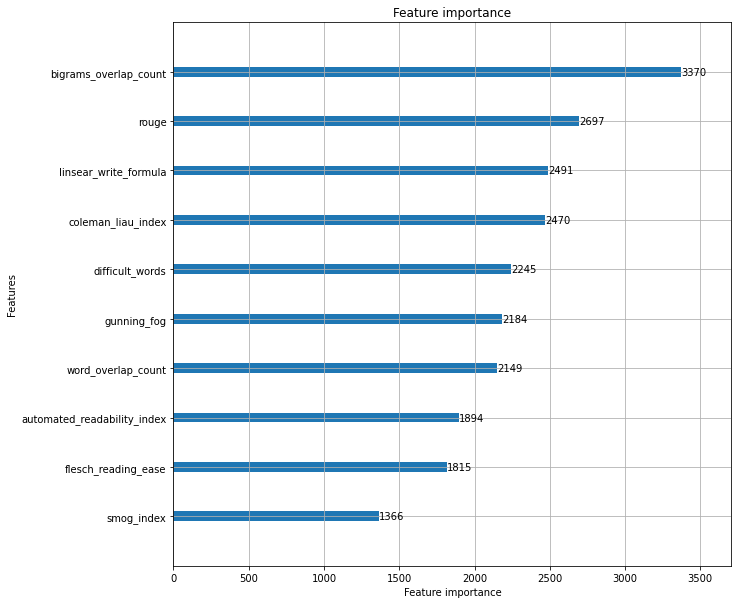

In [20]:
lgb.plot_importance(model.estimators_[0], figsize=(10, 10))

In [21]:
lgb.plot_tree(model.estimators_[0], figsize=(20, 20), orientation="vertical", dpi=2400)

<AxesSubplot: >

In [22]:
merged_test

,student_id,prompt_id,flesch_reading_ease,difficult_words,bigrams_overlap_count,automated_readability_index,coleman_liau_index,linsear_write_formula,gunning_fog,smog_index,word_overlap_count,rouge
0,000000ffffff,abc123,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0
1,222222cccccc,abc123,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0
2,111111eeeeee,def789,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0
3,333333dddddd,def789,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0


In [23]:
y_pred_final = model.predict(merged_test.drop(["student_id", "prompt_id"], axis=1))

In [24]:
y_pred_final_df = pd.DataFrame(y_pred_final, columns=["wording", "content"])
y_pred_final_df

,wording,content
0,-1.352929,-1.595628
1,-1.352929,-1.595628
2,-1.352929,-1.595628
3,-1.352929,-1.595628


In [25]:
merged_test_final = merged_test.merge(
    y_pred_final_df, left_index=True, right_index=True
)

In [26]:
merged_test_final

,student_id,prompt_id,flesch_reading_ease,difficult_words,bigrams_overlap_count,automated_readability_index,coleman_liau_index,linsear_write_formula,gunning_fog,smog_index,word_overlap_count,rouge,wording,content
0,000000ffffff,abc123,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0,-1.352929,-1.595628
1,222222cccccc,abc123,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0,-1.352929,-1.595628
2,111111eeeeee,def789,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0,-1.352929,-1.595628
3,333333dddddd,def789,59.97,1,0,-1.2,-2.38,1.5,14.53,0.0,0,0.0,-1.352929,-1.595628


In [27]:
out = merged_test_final[["student_id", "content", "wording"]]

In [28]:
out.to_csv("submission.csv", index=False)

In [37]:
import joblib

joblib.dump(model, "models/model.pkl")

['models/model.pkl']